# Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# !cp "drive/MyDrive/Question Generation/vae/models.py" .
%cd '/content/drive/MyDrive/Question Generation/vae/'
import json

Mounted at /content/drive
/content/drive/MyDrive/Question Generation/vae


# Objective 2: Answer-Aware Question Generation

In [ ]:
!pip install -q textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.3 MB/s eta 0:00:00


In [ ]:
import nltk
from nltk.translate.meteor_score import meteor_score
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
import textstat

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
!pip install -q -U sentence-transformers
from tqdm import tqdm
from sentence_transformers import SentenceTransformer,util
model = SentenceTransformer('all-MiniLM-L6-v2')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.9 MB/s eta 0:00:00


In [ ]:
def getScore(data):
  total_similarity_model = 0
  total_similarity_baseline = 0
  total_meteor_model = 0
  total_meteor_baseline = 0
  total_count = 0
  num_contexts = 0
  score_list = []
  for topic in data['data']:
    for paragraph in topic['paragraphs']:
      ## add context readability to make scatterchart
      passage_readability = textstat.smog_index(paragraph['context'])
      passage_length = len(paragraph['context'])
      num_contexts += 1
      sub_similarity_model = 0
      sub_similarity_baseline = 0
      sub_meteor_model = 0
      sub_meteor_baseline = 0
      sub_count = 0
      if paragraph['qas'] == []:
        continue
      for qa in paragraph['qas']:
        true_question = qa['question']
        model_gen_question = qa['generated_question']
        baseline_question_gen = qa['baseline_question_gen']
        model_meteor = meteor_score([word_tokenize(model_gen_question)], word_tokenize(true_question))
        baseline_meteor = meteor_score([word_tokenize(baseline_question_gen)], word_tokenize(true_question))
        embeddings = model.encode([true_question, model_gen_question,baseline_question_gen])
        cosine_similarity_model = util.cos_sim(embeddings,embeddings)[0,1]
        cosine_similarity_baseline = util.cos_sim(embeddings,embeddings)[0,2]


        sub_meteor_model += model_meteor
        sub_meteor_baseline += baseline_meteor     
        sub_similarity_model += cosine_similarity_model
        sub_similarity_baseline += cosine_similarity_baseline 
        sub_count += 1
        
      score_list.append([passage_length,passage_readability, sub_meteor_model/sub_count, sub_meteor_baseline/sub_count, sub_similarity_model/sub_count, sub_similarity_baseline/sub_count])
      total_similarity_model += sub_similarity_model
      total_similarity_baseline += sub_similarity_baseline
      total_meteor_model += sub_meteor_model
      total_meteor_baseline += sub_meteor_baseline
      total_count += sub_count
  print("Number of Contexts:", num_contexts)
  print("Number of Questions: ", total_count)
  print("Average Model BERT Similarity: ", total_similarity_model/total_count)
  print("Average Baseline BERT Similarity: ", total_similarity_baseline/total_count)
  print("Average Model METEOR Score: ", total_meteor_model/total_count)
  print("Average Baseline METEOR Score: ", total_meteor_baseline/total_count)
  return score_list


In [ ]:
with open('../data/squad/objective_output/my_test_final_output.json') as f:
  test_data = json.load(f)
with open('../data/squad/objective_output/train-v1.1_final_output.json') as f:
  train_data = json.load(f)
print("Finding score on test set: ")
test_score_list = getScore(test_data)
print("Finding score on train set: ")
train_score_list = getScore(train_data)

Finding score on test set: 
Number of Contexts: 530
Number of Questions:  1527
Average Model BERT Similarity:  tensor(0.6527)
Average Baseline BERT Similarity:  tensor(0.7332)
Average Model METEOR Score:  0.4021011125562633
Average Baseline METEOR Score:  0.5024445068178438
Finding score on train set: 
Number of Contexts: 299
Number of Questions:  2180
Average Model BERT Similarity:  tensor(0.7260)
Average Baseline BERT Similarity:  tensor(0.7394)
Average Model METEOR Score:  0.4718516952290674
Average Baseline METEOR Score:  0.4922055119413849


In [ ]:
import pickle
with open(f'../data/squad/objective_output/specific_question_generatio_test.pickle', 'wb') as f:
    pickle.dump(test_score_list, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'../data/squad/objective_output/specific_question_generatio_train.pickle', 'wb') as f:
    pickle.dump(train_score_list, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(f'../data/squad/objective_output/specific_question_generatio_test.pickle', 'rb') as h:
      test_score_list = pickle.load(h)
with open(f'../data/squad/objective_output/specific_question_generatio_train.pickle', 'rb') as h:
      train_score_list = pickle.load(h)

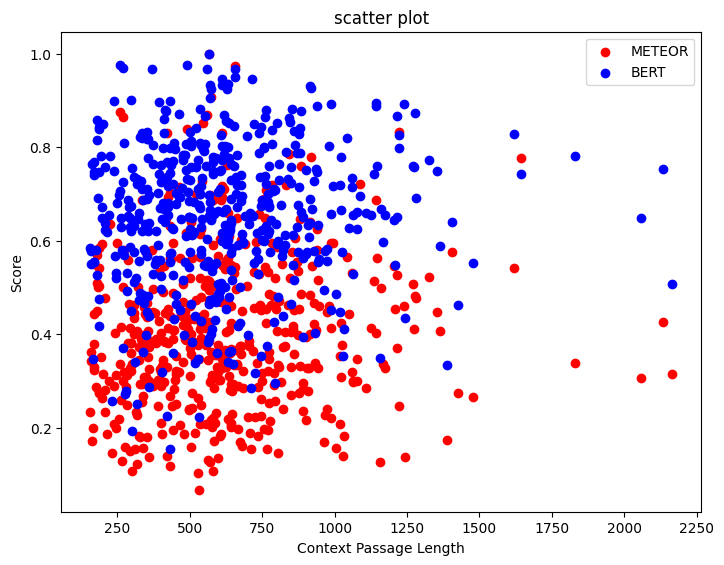

In [ ]:
import matplotlib.pyplot as plt

passage_length,readability_list, model_meteor_list, baseline_meteor_list, model_bert_list, baseline_bert_list = list(zip(*test_score_list))

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(passage_length, model_meteor_list, color='r', label='METEOR')
ax.scatter(passage_length, model_bert_list, color='b', label='BERT')
ax.legend()
ax.set_xlabel('Context Passage Length')
ax.set_ylabel('Score')
ax.set_title('scatter plot')
plt.show()

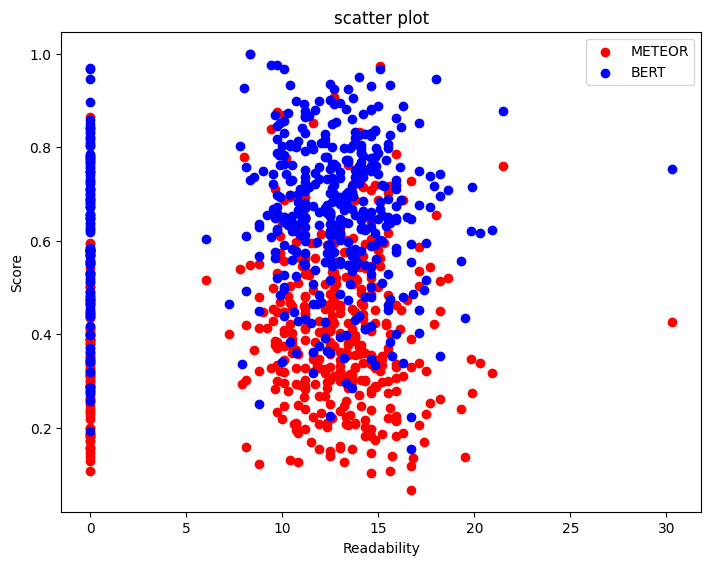

In [ ]:
import matplotlib.pyplot as plt

passage_length,readability_list, model_meteor_list, baseline_meteor_list, model_bert_list, baseline_bert_list = list(zip(*test_score_list))

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(readability_list, model_meteor_list, color='r', label='METEOR')
ax.scatter(readability_list, model_bert_list, color='b', label='BERT')
ax.legend()
ax.set_xlabel('Readability')
ax.set_ylabel('Score')
ax.set_title('scatter plot')
plt.show()

# Objective 3: Keyword Extraction

https://medium.com/gumgum-tech/exploring-different-keyword-extractors-evaluation-metrics-and-strategies-ef874d336773

In [ ]:
!pip install -q -U sentence-transformers
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from tqdm import tqdm
from sentence_transformers import SentenceTransformer,util
bert_model = SentenceTransformer('all-MiniLM-L6-v2').to(device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.7 MB/s eta 0:00:00


In [ ]:
!pip install -q rake-nltk
from tqdm import tqdm

In [ ]:
from rake_nltk import Rake
from collections import Counter
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def getScores(ref_set, pred_set):
    intersection = [x for x in ref_set if x in pred_set]
    em = len(intersection)
    if em == 0:
      return 0,0
    precision = len(intersection)/len(ref_set)
    recall = len(intersection)/len(pred_set)
    f1 = 2*precision*recall/(precision+recall)
    return em, f1

In [ ]:
import re
def preprocess(passage):
    # https://stackoverflow.com/questions/1276764/
    preprocess_pipeline = passage.lower()
    preprocess_pipeline = re.sub(r'[^a-zA-Z0-9]', ' ', preprocess_pipeline)
    preprocess_pipeline = preprocess_pipeline.split()
    return " ".join(preprocess_pipeline)

In [ ]:
import numpy as np
def getAllKeywordScores(data):
    model_em = 0
    model_f1 = 0
    baseline_em = 0
    baseline_f1 = 0
    count = 0
    all_model_predictions = []
    all_rake_predictions = []
    all_references = []
    for topic in data['data']:
      for paragraph in topic['paragraphs']:
        if paragraph['qas'] == []:
          continue
        
        references = [preprocess(qa['answers'][0]['text']) for qa in paragraph['qas']]
        model_keywords = [preprocess(keywordInfo[0]) for keywordInfo in paragraph['extracted_keywords']][:5]
        all_references.extend(references)  
        all_model_predictions.extend([preprocess(keywordInfo[0]) for keywordInfo in paragraph['extracted_keywords']])
        em, f1 = getScores(references, model_keywords)
        # print(em)
        model_em += em
        model_f1 += f1
        r = Rake()
        r.extract_keywords_from_text(paragraph['context'])
        rake_keywords_total = [preprocess(text) for text in r.get_ranked_phrases()][:5]
        rake_keyphrases = rake_keywords_total
        all_rake_predictions.extend(rake_keywords_total)
        em, f1 = getScores(references, rake_keyphrases)
        baseline_em += em
        baseline_f1 += f1
        count += 1

    baseline_em /= count
    baseline_f1 /= count
    model_em /= count
    model_f1 /= count
    
    print(f"\tBaseline Scores: EM = {baseline_em:0.1f}, F1 = {baseline_f1:0.4f}")
    print(f"\tModel Scores:\t EM = {model_em:0.1f}, F1 = {model_f1:0.4f}")

with open('../data/squad/objective_output/my_test_final_output.json') as f:
  test_data = json.load(f)
with open('../data/squad/objective_output/train-v1.1_final_output.json') as f:
  train_data = json.load(f)

print("On training data:")
getAllKeywordScores(train_data)
print("On testing data:")
getAllKeywordScores(test_data)

On training data:
	Baseline Scores: EM = 0.3, F1 = 0.0510
	Model Scores:	 EM = 4.8, F1 = 0.3101
On testing data:
	Baseline Scores: EM = 0.2, F1 = 0.0572
	Model Scores:	 EM = 1.2, F1 = 0.1401


In [ ]:
# Example passage
with open('../data/squad/objective_output/train-v1.1_final_output.json') as f:
  train_data = json.load(f)
for topic in train_data['data']:
  for paragraph in topic['paragraphs']:
    if "The College of Engineering was established in 1920," in paragraph['context']:
      print(paragraph['context'])
      references = [preprocess(qa['answers'][0]['text']) for qa in paragraph['qas']]
      model_keywords = [preprocess(keywordInfo[0]) for keywordInfo in paragraph['extracted_keywords']]  
      
      r = Rake()
      r.extract_keywords_from_text(paragraph['context'])
      rake_keywords_total = [preprocess(text) for text in r.get_ranked_phrases()]
      rake_keyphrases = rake_keywords_total
      print(rake_keyphrases)
      references = [preprocess(qa['answers'][0]['text']) for qa in paragraph['qas']]
      print(references)

The College of Engineering was established in 1920, however, early courses in civil and mechanical engineering were a part of the College of Science since the 1870s. Today the college, housed in the Fitzpatrick, Cushing, and Stinson-Remick Halls of Engineering, includes five departments of study – aerospace and mechanical engineering, chemical and biomolecular engineering, civil engineering and geological sciences, computer science and engineering, and electrical engineering – with eight B.S. degrees offered. Additionally, the college offers five-year dual degree programs with the Colleges of Arts and Letters and of Business awarding additional B.A. and Master of Business Administration (MBA) degrees, respectively.
['year dual degree programs', 'business awarding additional b', 'study aerospace', 'includes five departments', 'electrical engineering', 'college offers five', 'eight b', 'business administration', 'science since', 'remick halls', 'geological sciences', 'early courses', 'co

# Objective 11a: Context Identification

In [ ]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

#### Model Prediction

In [ ]:
with open('../data/squad/objective_output/contextIdentification_output.json') as f:
  questionCollated = json.load(f)

In [ ]:
qids = questionCollated.keys()
predicted_context_list = list()
true_context_list = list()
confidence_list = list()
incorrect_qids = list()
correct_counts = 0
incorrect_counts = 0
correct = 0
total = 0
for qid in qids:
  max_score = max([c[0] for c in questionCollated[qid]['contexts']])
  if max_score == questionCollated[qid]['contexts'][0][0]:
    correct += 1
  total += 1
  for contextInfo in questionCollated[qid]['contexts']:
    score = contextInfo[0]
    confidence_list.append(score)
    context_is_answer = contextInfo[1]
    correct_estimate = None
    if context_is_answer:
      true_context_list.append('Answer')
      correct_estimate = True
    else:
      true_context_list.append('Distractor')
    if score==max_score:
      predicted_context_list.append('Answer')
    else:
      predicted_context_list.append('Distractor')
      if correct_estimate == True:
        incorrect_qids.append(qid)
        
# https://www.w3schools.com/python/python_ml_confusion_matrix.asp
# confusion_matrix = metrics.confusion_matrix(true_context_list, predicted_context_list)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Answer', 'Distractor'])
# cm_display.plot()
# plt.show()
print("Model accuracy: ", correct/total)

Model accuracy:  0.7352941176470589


In [ ]:
print(incorrect_qids)
qid = incorrect_qids[4]
questionCollated[qid]

['100003', '100008', '100010', '100014', '100017', '100019', '100023', '100026', '100027']


{'question': 'What was the theme of Super Bowl 50?',
 'answer': 'gold',
 'contexts': [[0.16659554459711814,
   True,
   'Super_Bowl_50',
   'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.'],
  [0.28538359230336974,
   False,
   'Super_Bowl_50',
   'On June 4, 2014, the 

#### Baseline

In [ ]:
qids = questionCollated.keys()
correct = 0
total = 0
for qid in qids:
  max_score = max([c[0] for c in questionCollated[qid]['contexts']])
  context_text_list = [contextInfo[3] for contextInfo in questionCollated[qid]['contexts']]
  question_answer = [questionCollated[qid]['question'] + ". " + questionCollated[qid]['answer']]
  tfidfVectorizer = TfidfVectorizer()
  context_tfidfs = tfidfVectorizer.fit_transform(context_text_list)
  qa_tfids = tfidfVectorizer.transform(question_answer)
  cosine_similarities = linear_kernel(qa_tfids, context_tfidfs)
  
  if max(cosine_similarities[0]) == cosine_similarities[0,0]:
    correct += 1
  total += 1
print("Tf-IDf accuracy: ", correct/total)

Tf-IDf accuracy:  0.7058823529411765
